 # Code Description:

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22
Regularization is applied through use of scipy.optimize.curve_fit in the estimate_parameters function

This code is ultimately meant to compare the discrepency principle (DP), Generalized Cross-validation (GCV), and deep neural net regularization techniques to the oracle regularization when applied to real patient brain data

The brain data is quite large. A full run on a noise realization of the brain should take approximately 5 hours to run. NLLS takes approximately 2 min. GCV takes approximately 2 hours. Oracle lambda map takes approximately 2 hours.

The code was originally written by Ryan Neff and later developed by Griffin Hampton.

# Import Packages

In [185]:
#%matplotlib widget
import h5py
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
from tqdm import trange
from tensorflow.keras.models import load_model
import addcopyfighandler
from datetime import date
import sklearn
from sklearn.cluster import KMeans

# Options
When running the code, turn on and off options here. All options will manage fundamental coding features

In [186]:
add_noise = True   #Add noise to the data beyond what is there naturally
add_mask = True     #Add a mask to the data - this mask eliminates data below a threshold (mas_amplitude)

subsection = False   #Looks at a subsection of the figure in the region of (x,y) in [50:100,50:100] for all MR
#TODO - add an option to load or generate new data
#TODO = add an option that will suppress images
bounded = False    #bounds the T21 and T22 parameters below 40 and 300 - unbounded corresponds to a 1000 upper limit on both T2 parameters

# Define Parameters, Load Data, and Initialize Simple Functions

In [187]:
brain_data = scipy.io.loadmat('C:\\co\\NIA\\Regularization\\Brain_Maps\\data_MAP.mat')
if subsection:
    I_raw = brain_data['data_MAP'][50:100,50:100,:] #Subsection - speeds up computation - height, width, time
else:
    I_raw = brain_data['data_MAP']

#Loading in the control results - fitting without adding any additional noise
with h5py.File('Brain_Output//Basic_28Jul22.hdf5','a') as f:
    c1_ref = np.array(f['NLLS_params'])[:,:,0] 
#The brain data has a c1_MAP - RN believed that the map was determined through another fitting mechanism 
# --> it is likely better to start building the c1_ref from scratch
#c1_ref = scipy.io.loadmat('C:\\Users\\neffrya\Documents\Regularization Project\Brain dataset\\High SNR data\\c1_MAP.mat')['c1_MAP']


#n_hori, n_vert, n_slices, n_elements_brain = I_raw.shape  - #if I_raw is a 4D struc
n_hori, n_vert, n_elements_brain = I_raw.shape
t_increment_brain = 11.3 #This is a measurement originally indicated by Chuan Bi in the initial email about this data
tdata_brain = np.linspace(t_increment_brain, (n_elements_brain)*(t_increment_brain), n_elements_brain)
if bounded:
    upper_bound_brain = [1,1,40,300]
else:
    upper_bound_brain = [1,1,1000,1000]
initial_brain = (0.5, 0.5, 20, 100) #default start when fitting parameters
mask_amplitude = 600#767#600                #GSH - Is there a mask amplitude that would be good to fit here?
lambdas = np.logspace(-7, 3, 51)    #GSH - Should this be higher resolution? Do we need to go down to -7?
ob_weight = 100                     #GSH - what purpose does this start with?

SNR_brain = 100

#NESMA Filter parameters
txy = 3
# tz = 5  #unused
thresh = 5



#File naming information
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')
if add_noise:
    output_fileName = "SNR_" + str(SNR_brain) + "_" + day + month + year
else:
    output_fileName = "Basic_" + day + month + year

if subsection:
    output_fileName = "subS_" + output_fileName

if not bounded:
    output_fileName = "unBound_" + output_fileName



#Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_tilde(lam, SA = 1):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    def Gt_lam(t, con1, con2, tau1, tau2):
        return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

def G_tilde_linear(T21, T22, lam):
    def G_linear(t, c1, c2):
        return np.append(G(t, c1, c2, T21, T22), [lam*c1, lam*c2])
    return G_linear

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

### Load in Already Processed Data

In [188]:
#Load in parameter maps for the different methods
# with h5py.File('Brain_Output//SNR_10000_26Jul22.hdf5','a') as f:
#     parameter_maps_NLLS = np.array(f['NLLS_params'])
#     parameter_maps_GCV = np.array(f['GCV_params'])

# Define Regularization and Brain Functions

In [189]:
def NESMA_filtering(raw,txy,tz,thresh,verbose=False):
    #Inputs:
    # raw    : 4D (x,y,z,MS) raw/noisy volume. x,y and z/slice are the spatial coordinates, while MS is the multispectral dimension
    # txy    : Defines the size, (2*txy+1)-by-(2*txy+1) in voxels, of the search window in the x-y plane.
    # tz     : Defines the size, (2*tz+1) in voxels, of the search window in the z direction (a.k.a slice direction).
    # thresh : 100%-thresh defines the similarity threshold (%). Values between 1% to 10% are recommended.
    
    # Output:
    # S_NESMA: 4D (x,y,z,MS) NESMA-filtered volume
    
    (m,n,o,p) = raw.shape
    S_NESMA = np.zeros((m,n,o,p))
    
    for k in trange(o):
        if verbose==True:
            print('NESMA filtering ... Slice #', k, 'of', o)
        for i in range(m):
            for j in range(n):
                if raw[i,j,k,0]>10:
                    rmin=max(i-txy,0)
                    rmax=min(i+txy,m)
                    
                    smin=max(j-txy,0)
                    smax=min(j+txy,n)
                    
                    tmin=max(k-tz,0)
                    tmax=min(k+tz,o)
                    
                    L = (rmax-rmin)*(smax-smin)*(tmax-tmin)
                    
                    rawi = np.reshape(raw[rmin:rmax,smin:smax,tmin:tmax,:],(L,p))
                    x=raw[i,j,k,:]
                    
                    D = 100*np.sum(abs(rawi-x),axis=1)/np.sum(x)
                    pos = D<thresh
                    
                    S_NESMA[i,j,k,:] = np.mean(rawi[pos==True, :], axis=0)
                    
    return S_NESMA

def mask_data(raw, mask_amplitude):
    #Sets every decay curve in the data set where the amplitude is less than a threshold value to zero
    I_masked = np.copy(raw)
    I_masked[I_masked[:,:,0]<mask_amplitude] = 0
    return I_masked

def add_noise_brain(raw, SNR_brain):
    #Add noise to the image
    I_noised = np.zeros(raw.shape)
    # max_signal = np.max(raw)
    # brain_noise_sd = max_signal/SNR_brain
    for i_hori in range(n_hori):
        for i_vert in range(n_vert):
            underlying = raw[i_hori, i_vert, :]
            max_signal = underlying[0]
            brain_noise_sd = max_signal/SNR_brain
            data = underlying + np.random.normal(0, brain_noise_sd, len(underlying))
            I_noised[i_hori,i_vert,:] = data
    return I_noised

def NESMA_filtering_3D(raw,txy,thresh,verbose=False):
    #Inputs:
    # raw    : 3D (x,y,MS) raw/noisy volume. x,y are the spatial coordinates, while MS is the multispectral dimension
    # txy    : Defines the size, (2*txy+1)-by-(2*txy+1) in voxels, of the search window in the x-y plane.
    # thresh : 100%-thresh defines the similarity threshold (%). Values between 1% to 10% are recommended.

    # Output:
    # S_NESMA: 3D (x,y,MS) NESMA-filtered volume
    
    (m,n,o) = raw.shape
    S_NESMA = np.zeros((m,n,o))
    
    for j in trange(n):
        if verbose==True and j%50==0:
            print('NESMA filtering ... Slice #', j, 'of', n)
        for i in range(m):
            rmin=max(i-txy,0)
            rmax=min(i+txy,m)
                    
            smin=max(j-txy,0)
            smax=min(j+txy,n)
                    
            L = (rmax-rmin)*(smax-smin)
                    
            rawi = np.reshape(raw[rmin:rmax,smin:smax,:],(L,o)) #GSH - Different than the 4D version but seems appropriate
            x=raw[i,j,:]
                    
            D = 100*np.sum(abs(rawi-x),axis=1)/np.sum(x)
            pos = D<thresh
                    
            S_NESMA[i,j,:] = np.mean(rawi[pos==True,:], axis=0)
    
    return S_NESMA

def estimate_NLLS_brain(data, lam=0, expt_knowledge = [0,0,0,0], up_bound = upper_bound_brain):
    SA = 1#data[0]
    data_tilde = np.append(data, lam*np.array(expt_knowledge))
    (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(
        G_tilde(lam, SA = SA), tdata_brain, data_tilde, bounds = ([0,0,0,0], up_bound), p0=initial_brain, max_nfev = 4000)
    
    if rT22e > rT21e:
        c1est = rc1e
        c2est = rc2e
        T21est = rT21e
        T22est = rT22e
    else:
        c1est = rc2e
        c2est = rc1e
        T21est = rT22e
        T22est = rT21e
    #Assume c1 + c2 = 1
    ci_sum = c1est + c2est
    c1est = c1est/ci_sum
    c2est = c2est/ci_sum
        
    return c1est, c2est, T21est, T22est

def create_NLLS_map(raw):
    #Given raw data, create unregularized NLLS maps of c1, c2, T21, and T22
    parameter_maps_NLLS = np.zeros((n_hori, n_vert, 4))
    for i_hori in trange(n_hori):
        for i_vert in range(n_vert):
            data = raw[i_hori,i_vert,:]
            if data[0]>0:
                #Adjust the decay curve so that the amplitude is roughly 1
                #data = data/data[0]
                est = np.array(estimate_NLLS_brain(data))
                #After applying NLLS, normalize so that c1 + c2 = 1
                parameter_maps_NLLS[i_hori,i_vert,:] = est
            else:
                parameter_maps_NLLS[i_hori,i_vert,:] = np.zeros(4)
    return parameter_maps_NLLS

def oracle_lambda_brain(ref_val, data, lambdas, param_idx):
    #Given a reference value of the parameter of interest, the data set, a set of lambdas, and the index of the parameter,
    #return the lambda which gives the least absolute error for that parameter
    error_list = []
    for lam in lambdas:
        est = np.array(estimate_NLLS_brain(data, lam))
        param_error = np.absolute(est[param_idx]-ref_val)
        error_list.append(param_error)
        
    min_error_idx = np.argmin(error_list)
    oracle_lam = lambdas[min_error_idx]
    return oracle_lam

def get_GCV_brain(GCV_data, GCV_lam):

    c1GCV, c2GCV, T21GCV, T22GCV = estimate_NLLS_brain(GCV_data, lam=GCV_lam)

    wmat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
    
    GCVjacobian = J(tdata_brain, c1GCV, c2GCV, T21GCV, T22GCV)
    GCV_residual = ((G(tdata_brain, c1GCV, c2GCV, T21GCV, T22GCV)-GCV_data)**2).sum()
    C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(GCV_lam**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
    #C_GCV = np.dot(np.dot(GCVjacobian, np.linalg.inv(np.dot(GCVjacobian.transpose(), GCVjacobian) + (GCV_lam**2)*np.dot(wmat.transpose(),wmat))),GCVjacobian.transpose())
    # assert(C_GCV_prior == C_GCV)
    (n,n) = C_GCV.shape
    identity = np.identity(n)

    GCVdenominator = (identity - C_GCV).trace()

    GCV = GCV_residual/(GCVdenominator**2)
    return GCV

def GCV_lambda_brain(GCV_data, GCVlambdas):
    #Given a data set and a set of lambdas to iterate through, gives the lambda which minimizes the GCV equation
    GCV_values = []
    for GCVlam in GCVlambdas:
        GCV_values.append(get_GCV_brain(GCV_data, GCVlam))
    GCV_lam = GCVlambdas[np.argmin(GCV_values)]
    return GCV_lam, GCV_values

def create_GCV_map(raw, lambdas):
    parameter_maps_GCV = np.zeros((n_hori, n_vert, 4))
    lambda_map_GCV = np.zeros((n_hori, n_vert))
    for i_hori in trange(n_hori):
        for i_vert in range(n_vert):
            data = raw[i_hori,i_vert,:]
            #Check if there is signal present
            if data[0] > 0:
                #data = data/data[0]
                try:
                    GCVlam, GCV_values = GCV_lambda_brain(data, lambdas) #GSH - needs to be set to two different values
                    lambda_map_GCV[i_hori,i_vert] = GCVlam
                    est = np.array(estimate_NLLS_brain(data,lam=GCVlam))
                    parameter_maps_GCV[i_hori,i_vert,:] = est
                except:
                    parameter_maps_GCV[i_hori,i_vert,:] = np.zeros(4)
                    lambda_map_GCV[i_hori,i_vert] = 0
            #If no signal, return zero for all parameters
            else:
                parameter_maps_GCV[i_hori,i_vert,:] = np.zeros(4)
                lambda_map_GCV[i_hori,i_vert] = 0
    return parameter_maps_GCV, lambda_map_GCV

# def DNN_lambda_brain(DNN_data):
#     #Given a data set, determine the appropriate network to use and apply it ot find lambda
#     #Here, use networks trained at SNR = 10, 50, 100, 175, and 300
#     signal_end = DNN_data[(n_elements_brain-10):]
            
#     brain_noise_sd = np.std(signal_end)
#     brain_SNR = DNN_data[0]/brain_noise_sd
#     if brain_SNR < 30:
#         model = load_model('DNN Networks//brain reg model SNR 10 3-25.h5')
#     elif brain_SNR >= 30 and brain_SNR < 75:
#         model = load_model('DNN Networks//brain reg model SNR 50 3-25.h5')
#     elif brain_SNR >= 75 and brain_SNR < 125:
#         model = load_model('DNN Networks//brain reg model SNR 100 3-29.h5')
#     elif brain_SNR >= 125 and brain_SNR < 225:
#         model = load_model('DNN Networks//brain reg model SNR 175 3-29.h5')
#     else:
#         model = load_model('DNN Networks//brain reg model SNR 300 3-29.h5')
    
#     DNN_data = np.reshape(DNN_data, (1,n_elements_brain))
#     logDNN_lam = np.array(model(DNN_data))
#     DNN_lam = 10**logDNN_lam
#     return DNN_lam

# def create_DNN_map(raw, all_SNR):
#     #all_SNR = True uses a single network trained over all the SNR
#     #all_SNR = False uses multiple networks each trained over a single SNR
#     if all_SNR:
#         model_brain = load_model('DNN Networks//brain reg model 1 norm ALL SNR 5-4.h5')
#         DNN_data = raw.copy()
#         DNN_data_flat = np.reshape(DNN_data,(n_hori*n_vert,n_elements_brain))
#         #Normalize the flattened array to get DNN lambdas
#         #for i in range(n_hori*n_vert):
#             #SA = DNN_data_flat[i,0]
#             #if SA > 0:
#                 #DNN_data_flat[i,:] = DNN_data_flat[i,:]/SA
#         DNN_lambdas_brain = model_brain(DNN_data_flat)
                    
#     parameter_maps_DNN = np.zeros((n_hori, n_vert, 4))
#     lambda_map_DNN = np.zeros((n_hori,n_vert))
#     iterator = 0
#     for i_hori in trange(n_hori):
#         for i_vert in range(n_vert):
#             data = raw[i_hori,i_vert,:]
#             #Check if there is signal present
#             if data[0] > 0:
#                 #data = data/data[0]
#                 if all_SNR:
#                     DNN_lam = 10**DNN_lambdas_brain[iterator]
#                 else:
#                     DNN_lam = 10**(DNN_lambda_brain(data))
#                 lambda_map_DNN[i_hori,i_vert] = DNN_lam
#                 est = np.array(estimate_NLLS_brain(data,lam=DNN_lam))
#                 parameter_maps_DNN[i_hori,i_vert,:] = est
#             #If no signal, return zero for all parameters
#             else:
#                 parameter_maps_DNN[i_hori,i_vert,:] = np.zeros(4)
#             iterator += 1
#     return parameter_maps_DNN, lambda_map_DNN

# Processing Data

In [190]:
#Processing of all the data to noised, masked, and filtered versions

# #Add noise to the image
if add_noise:
    I_noised = add_noise_brain(I_raw, SNR_brain)
else:
    I_noised = I_raw

#Create a mask for unwanted sections
if add_mask:
    I_masked = mask_data(I_noised, mask_amplitude)
else:
    I_masked = I_noised

I_filtered = NESMA_filtering_3D(I_masked, txy, thresh, verbose = True)

  0%|          | 0/161 [00:00<?, ?it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_22352\769646810.py:88: RuntimeWarning: invalid value encountered in divide
  D = 100*np.sum(abs(rawi-x),axis=1)/np.sum(x)
c:\co\NIA\.venv\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\co\NIA\.venv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
  4%|▍         | 7/161 [00:00<00:02, 62.67it/s]

NESMA filtering ... Slice # 0 of 161


 14%|█▎        | 22/161 [00:00<00:02, 68.32it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_22352\769646810.py:88: RuntimeWarning: divide by zero encountered in divide
  D = 100*np.sum(abs(rawi-x),axis=1)/np.sum(x)
 36%|███▌      | 58/161 [00:00<00:01, 65.50it/s]

NESMA filtering ... Slice # 50 of 161


 71%|███████▏  | 115/161 [00:01<00:00, 73.67it/s]

NESMA filtering ... Slice # 100 of 161


100%|██████████| 161/161 [00:02<00:00, 69.20it/s]

NESMA filtering ... Slice # 150 of 161


In [191]:
#Normalize the data before making parameter maps
I_normalized = np.zeros((n_hori,n_vert,n_elements_brain))
for i_hori in trange(n_hori):
    for i_vert in range(n_vert):
        data = I_filtered[i_hori,i_vert]
        if data[0]>0:
            data_normalized = data/data[0] #GSH - normalizing by the maximum signal - comes from the highest MRI signal
        else:
            data_normalized = np.zeros(n_elements_brain)
        I_normalized[i_hori,i_vert,:] = data_normalized

100%|██████████| 191/191 [00:00<00:00, 1936.68it/s]


# Initial Visualization of Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


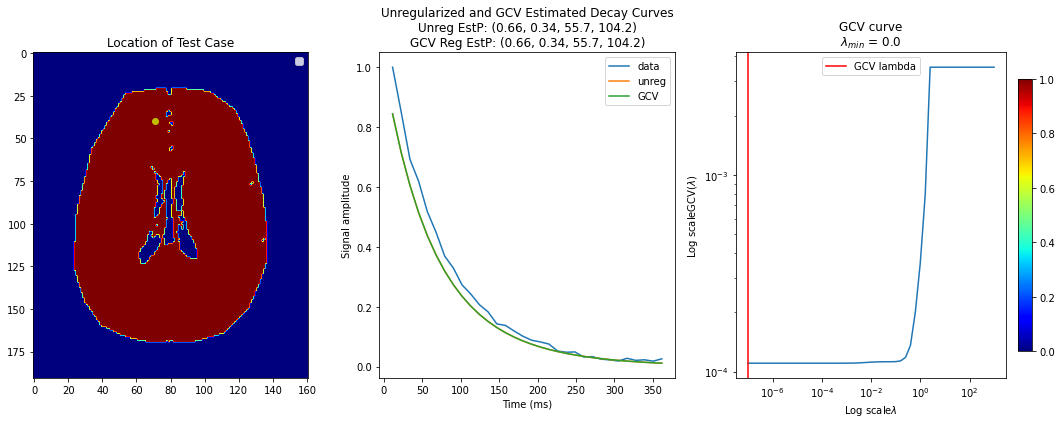

In [192]:
test_data = I_normalized[int(n_hori/8*3), int(n_vert/4), :]   #[125,75,:]
lam, GCV_curve = GCV_lambda_brain(test_data, lambdas)
c1n, c2n,T21n,T22n = estimate_NLLS_brain(test_data)
c1g, c2g,T21g,T22g = estimate_NLLS_brain(test_data, lam=lam)
fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(15,6))
unR_pList = ', '.join(str(x) for x in (round(c1n,2), round(c2n,2), round(T21n,1), round(T22n,1)))
GCV_pList = ', '.join(str(x) for x in (round(c1g,2), round(c2g,2), round(T21g,1), round(T22g,1)))
ax[1].plot(tdata_brain, test_data, label='data')
ax[1].plot(tdata_brain, G(tdata_brain, c1n, c2n, T21n, T22n), label='unreg')
ax[1].plot(tdata_brain, G(tdata_brain, c1g, c2g, T21g, T22g), label='GCV')
ax[1].legend()
ax[1].set_ylabel('Signal amplitude')
ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Unregularized and GCV Estimated Decay Curves' +
                '\nUnreg EstP: (' + unR_pList + ')' +
                '\nGCV Reg EstP: (' + GCV_pList + ')')

ax[2].loglog(lambdas, GCV_curve)
ax[2].axvline(x=lam, color='r', label='GCV lambda')
ax[2].legend()
ax[2].set_ylabel('Log scale' + 'GCV(' + r'$\lambda$' + ')')
ax[2].set_xlabel('Log scale' + r'$\lambda$')
ax[2].set_title('GCV curve' + 
                '\n' + r'$\lambda_{min}$' + ' = ' + str(round(lam,2)))

imc1 = ax[0].imshow(I_normalized[:, :, 0], cmap = 'jet')
imc2 = ax[0].scatter(int(n_hori/8*3),int(n_vert/4), color='y')
ax[0].set_title('Location of Test Case')
ax[0].legend()
fig.colorbar(imc1, ax=ax[2], fraction=0.046, pad=0.04)

plt.show()

### Calculating SNR of a Brain Region

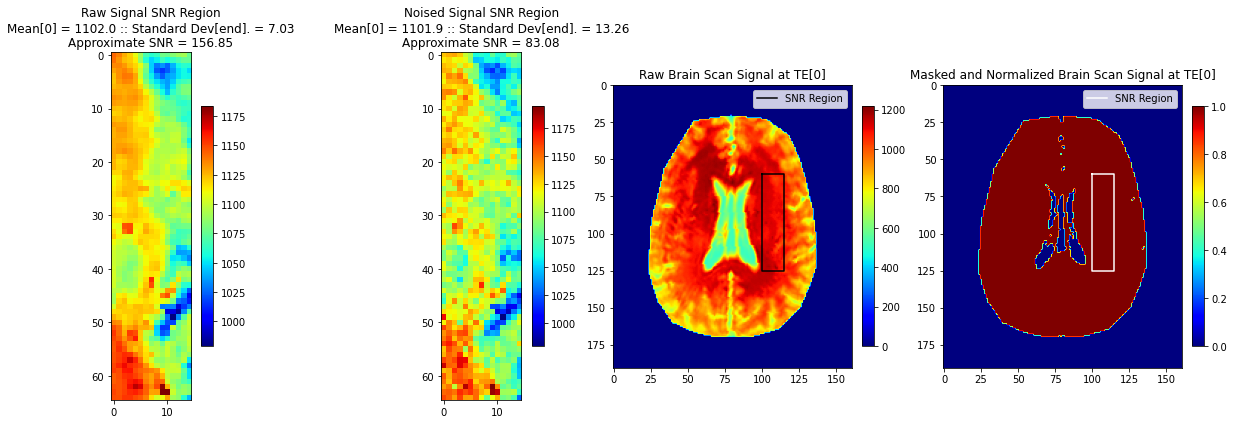

In [193]:
#Regions: (v1, v2, h1, h2)
#White Matter = (60, 125, 100, 115)
#Ventricles = (108, 116, 86, 93)

vert1 = 60             #60     #108
vert2 = 125            #125     #116
hori1 = 100            #100      #86
hori2 = 115            #115      #93
vBox = (vert1,vert1,vert2,vert2,vert1)
hBox = (hori1,hori2,hori2,hori1,hori1)

SNR_regionZero = I_raw[vert1:vert2, hori1:hori2, 0]
SNR_regionZero_mean = np.mean(SNR_regionZero)

SNR_regionEnd = I_raw[vert1:vert2, hori1:hori2, n_elements_brain-1]
SNR_regionEnd_std = np.std(SNR_regionEnd)

approx_brainSNR = round(SNR_regionZero_mean/SNR_regionEnd_std,2)

if  not add_noise:
    SNR_brain = approx_brainSNR

nSNR_regionZero = I_noised[vert1:vert2, hori1:hori2, 0]
nSNR_regionZero_mean = np.mean(nSNR_regionZero)

nSNR_regionEnd = I_noised[vert1:vert2, hori1:hori2, n_elements_brain-1]
nSNR_regionEnd_std = np.std(nSNR_regionEnd)

napprox_brainSNR = round(nSNR_regionZero_mean/nSNR_regionEnd_std,2)


fig, ax = plt.subplots(1,4,figsize=(18,6),tight_layout=True)

imc1 = ax[0].imshow(SNR_regionZero, cmap = 'jet')
ax[0].set_title('Raw Signal SNR Region' +
                '\nMean[0] = ' + str(round(SNR_regionZero_mean,2)) + ' :: Standard Dev[end]. = ' + str(round(SNR_regionEnd_std,2)) +
                '\nApproximate SNR = ' + str(approx_brainSNR) )
fig.colorbar(imc1, ax=ax[0], fraction=0.046, pad=0.04)

imc2 = ax[1].imshow(nSNR_regionZero, cmap = 'jet')
ax[1].set_title('Noised Signal SNR Region' +
                '\nMean[0] = ' + str(round(nSNR_regionZero_mean,2)) + ' :: Standard Dev[end]. = ' + str(round(nSNR_regionEnd_std,2)) +
                '\nApproximate SNR = ' + str(napprox_brainSNR) )
fig.colorbar(imc2, ax=ax[1], fraction=0.046, pad=0.04)

imc3 = ax[2].imshow(I_raw[:, :, 0], cmap = 'jet')
ax[2].set_title('Raw Brain Scan Signal at TE[0]')
ax[2].plot(hBox,vBox, color='k', label = "SNR Region")
ax[2].legend()
fig.colorbar(imc3, ax=ax[2], fraction=0.046, pad=0.04)

imc4 = ax[3].imshow(I_normalized[:, :, 0], cmap = 'jet')
ax[3].set_title('Masked and Normalized Brain Scan Signal at TE[0]')
ax[3].plot(hBox,vBox, color='w',label = "SNR Region")
fig.colorbar(imc4, ax=ax[3], fraction=0.046, pad=0.04)
ax[3].legend()
plt.show()





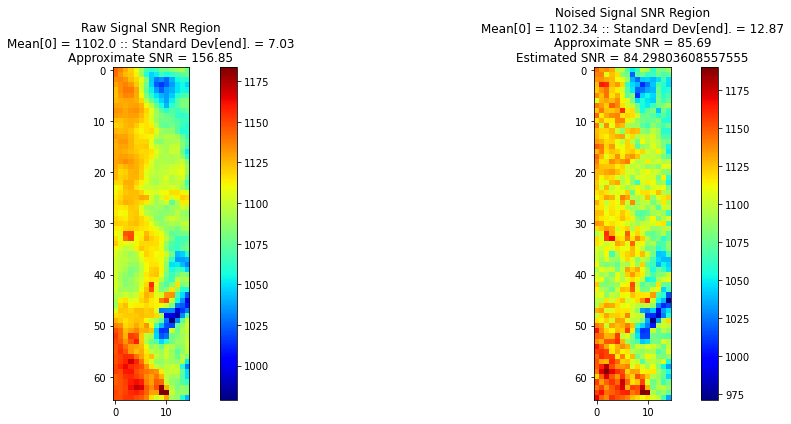

In [213]:
vert1 = 60             #60     #108
vert2 = 125            #125     #116
hori1 = 100            #100      #86
hori2 = 115            #115      #93
vBox = (vert1,vert1,vert2,vert2,vert1)
hBox = (hori1,hori2,hori2,hori1,hori1)

rawZone = I_raw[vert1:vert2, hori1:hori2, :]

SNR_regionZero = rawZone[:, :, 0]
SNR_regionZero_mean = np.mean(SNR_regionZero)
SNR_regionEnd = rawZone[:, :, n_elements_brain-1]
SNR_regionEnd_std = np.std(SNR_regionEnd)
approx_brainSNR = round(SNR_regionZero_mean/SNR_regionEnd_std,2)

rawNoise = 0
rawNoised = np.zeros(rawZone.shape)

for i_hori in range(rawZone.shape[0]):
    for i_vert in range(rawZone.shape[1]):
        underlying = rawZone[i_hori, i_vert, :]
        max_signal = underlying[0]
        brain_noise_sd = max_signal/SNR_brain
        rawNoise += brain_noise_sd**2
        data = underlying + np.random.normal(0, brain_noise_sd, len(underlying))
        rawNoised[i_hori,i_vert,:] = data

numZone = rawZone.shape[0]*rawZone.shape[1]
estNoiseStd = ((SNR_regionEnd_std**2*numZone + rawNoise)/numZone)**(1/2)
estSNR = SNR_regionZero_mean/estNoiseStd

nSNR_regionZero = rawNoised[:, :, 0]
nSNR_regionZero_mean = np.mean(nSNR_regionZero)
nSNR_regionEnd = rawNoised[:, :, n_elements_brain-1]
nSNR_regionEnd_std = np.std(nSNR_regionEnd)
napprox_brainSNR = round(nSNR_regionZero_mean/nSNR_regionEnd_std,2)


fig, ax = plt.subplots(1,2,figsize=(18,6),tight_layout=True)

imc1 = ax[0].imshow(SNR_regionZero, cmap = 'jet')
ax[0].set_title('Raw Signal SNR Region' +
                '\nMean[0] = ' + str(round(SNR_regionZero_mean,2)) + ' :: Standard Dev[end]. = ' + str(round(SNR_regionEnd_std,2)) +
                '\nApproximate SNR = ' + str(approx_brainSNR) )
fig.colorbar(imc1, ax=ax[0], fraction=0.046, pad=0.04)

imc2 = ax[1].imshow(nSNR_regionZero, cmap = 'jet')
ax[1].set_title('Noised Signal SNR Region' +
                '\nMean[0] = ' + str(round(nSNR_regionZero_mean,2)) + ' :: Standard Dev[end]. = ' + str(round(nSNR_regionEnd_std,2)) +
                '\nApproximate SNR = ' + str(napprox_brainSNR) +
                '\nEstimated SNR = ' + str(estSNR))
fig.colorbar(imc2, ax=ax[1], fraction=0.046, pad=0.04)

### KMeans Regions

Text(0, 0.5, 'Within Cluster Square Sum (WSS)')

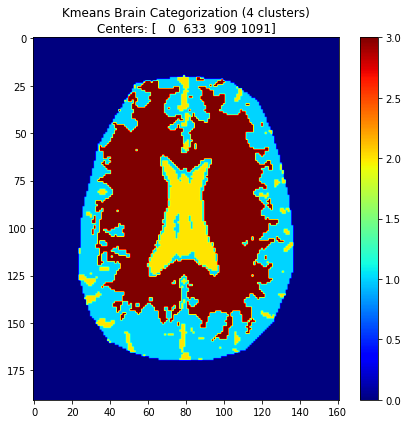

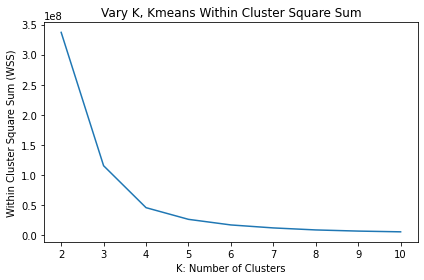

In [194]:
I_raw_linear = np.reshape(I_raw[:,:,0],(-1,1))

num_clusters = 4

kmeans = KMeans(n_clusters = num_clusters).fit(I_raw_linear)

kmeans_return = kmeans.labels_
kmeans_centers = np.array(kmeans.cluster_centers_)
kmeans_rebuilt = np.reshape(kmeans_return,I_raw[:,:,0].shape)

rounded_centers = kmeans_centers.astype(int)
rounded_centers = np.reshape(rounded_centers,(1,-1))
rounded_centers.sort()
centers_List = ', '.join(str(x) for x in rounded_centers)

fig, ax = plt.subplots(figsize=(8,6),tight_layout=True)
imc1 = ax.imshow(kmeans_rebuilt, cmap = 'jet')
ax.set_title("Kmeans Brain Categorization (" + str(num_clusters)+ " clusters)" +
            "\nCenters: "+ centers_List)
fig.colorbar(imc1, fraction=0.046, pad=0.04)


def calculate_WSS(data,data_categories,centers):
    num_clusters = centers.shape[0]

    WSS = 0
    for i in range(num_clusters):
        category_mat = (data_categories==i)
        WSS += np.sum((data - centers[i])**2 * category_mat)

    return WSS

optK_WSS = np.zeros((9,1))
for i in range(0,9):
    kmeans = KMeans(n_clusters = i+2).fit(I_raw_linear)

    kmeans_return = kmeans.labels_
    kmeans_centers = kmeans.cluster_centers_
    kmeans_rebuilt = np.reshape(kmeans_return,I_raw[:,:,0].shape)

    optK_WSS[i] = calculate_WSS(I_raw[:,:,0],kmeans_rebuilt,kmeans_centers)

fig, ax = plt.subplots(figsize=(6,4),tight_layout=True)
ax.plot(np.arange(2,11,1),optK_WSS)
ax.set_title("Vary K, Kmeans Within Cluster Square Sum")
ax.set_xlabel("K: Number of Clusters")
ax.set_ylabel("Within Cluster Square Sum (WSS)")



In [195]:
#Normalize the NESMA filtered data and account for Rician noise
I_norm_NESMA = np.zeros((n_hori,n_vert,n_elements_brain))
for i_hori in trange(n_hori):
    for i_vert in range(n_vert):
        #for i_slice in range(n_slices):
        data = I_filtered[i_hori,i_vert,:]
            #Account for the Rician noise
        signal_end = data[(n_elements_brain-10):]
        rician_correction = np.mean(signal_end)
        data_shifted = data-rician_correction
            #Normalize the data
        data_shifted = np.array(data_shifted/data_shifted[0])

        I_norm_NESMA[i_hori,i_vert,:] = data_shifted

100%|██████████| 191/191 [00:00<00:00, 336.15it/s]


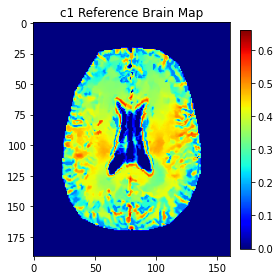

In [196]:
fig, ax = plt.subplots(figsize=(4,4),tight_layout=True)
imc1 = ax.imshow(c1_ref, cmap = 'jet')
ax.set_title('c1 Reference Brain Map')
fig.colorbar(imc1,ax=ax,fraction=0.046, pad=0.04)
plt.show()

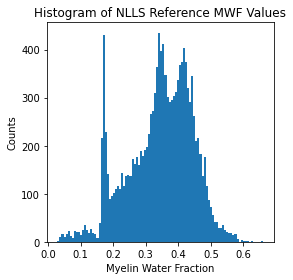

In [197]:
fig, ax = plt.subplots(figsize=(4,4),tight_layout=True)
hh = ax.hist(c1_ref[c1_ref>0].ravel(), 100, density=False)
ax.set_title('Histogram of NLLS Reference MWF Values')
ax.set_ylabel('Counts')
ax.set_xlabel('Myelin Water Fraction')
plt.show()

100%|██████████| 191/191 [00:00<00:00, 451.55it/s]


SNR mean: 83.95050729080707


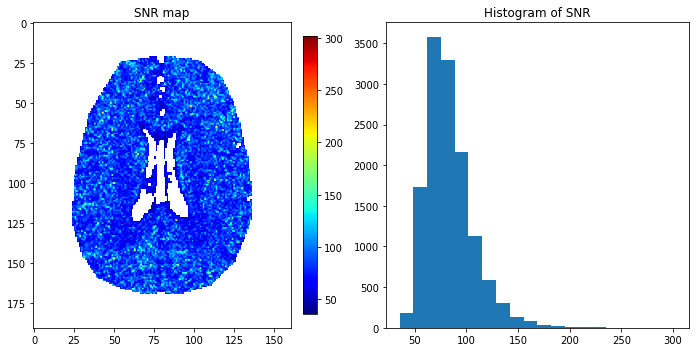

In [198]:
#Show a map of SNR in the image
brain_SNR_map = np.zeros((n_hori, n_vert))
for i_hori in trange(n_hori):
    for i_vert in range(n_vert):
        data = I_masked[i_hori,i_vert,:]
        if data[0] > 0:
            signal_end = data[(n_elements_brain-10):]
            
            brain_noise_sd = np.std(signal_end)
            brain_SNR = data[0]/brain_noise_sd
            brain_SNR_map[i_hori, i_vert] = brain_SNR
        else:
            brain_SNR_map[i_hori, i_vert] = None


fig, ax = plt.subplots(1, 2, figsize=(10,5),tight_layout=True)
imc1 = ax[0].imshow(brain_SNR_map, cmap = 'jet')#, norm=mpl.colors.LogNorm())
ax[0].set_title('SNR map')
n, bins, patches = ax[1].hist(np.reshape(brain_SNR_map[brain_SNR_map>0],-1), bins=20)
bincenters = 0.5*(bins[1:]+bins[:-1])
#print(bincenters)
print('SNR mean:',np.mean(brain_SNR_map[brain_SNR_map>0]))
ax[1].set_title('Histogram of SNR')
fig.colorbar(imc1,ax=ax[0],fraction=0.046, pad=0.04)
plt.show()

# Processing and Images of Data with the NESMA Filter

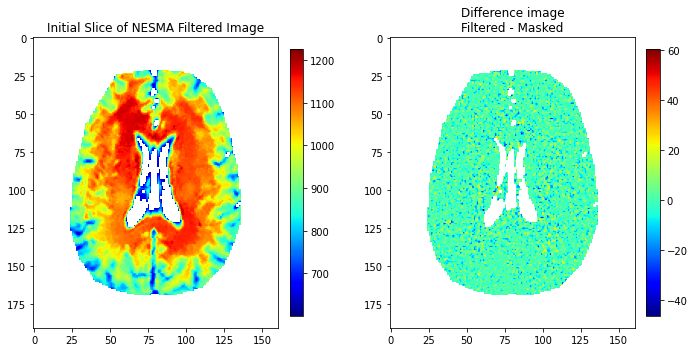

In [199]:
signal_strength_filtered = I_filtered[:,:,0]
signal_strength_masked = I_masked[:,:,0]
fig, ax = plt.subplots(1,2, figsize=(10,5),tight_layout=True)
imc1 = ax[0].imshow(signal_strength_filtered, cmap = 'jet')
imc2 = ax[1].imshow(signal_strength_filtered - signal_strength_masked, cmap = 'jet')
ax[0].set_title('Initial Slice of NESMA Filtered Image')
ax[1].set_title('Difference image' +
                '\nFiltered - Masked')
fig.colorbar(imc1,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(imc2,ax=ax[1],fraction=0.046, pad=0.04)

plt.show()

In [200]:
#Normalize the NESMA filtered data and account for Rician noise
I_norm_NESMA = np.zeros((n_hori,n_vert,n_elements_brain))
for i_hori in trange(n_hori):
    for i_vert in range(n_vert):
        #for i_slice in range(n_slices):
        data = I_filtered[i_hori,i_vert,:]
            #Account for the Rician noise
        signal_end = data[(n_elements_brain-10):]
        rician_correction = np.mean(signal_end)
        data_shifted = data-rician_correction
            #Normalize the data
        data_shifted = np.array(data_shifted/data_shifted[0])

        I_norm_NESMA[i_hori,i_vert,:] = data_shifted

100%|██████████| 191/191 [00:00<00:00, 207.75it/s]


100%|██████████| 191/191 [00:00<00:00, 486.21it/s]


SNR mean: 97.2122143251381


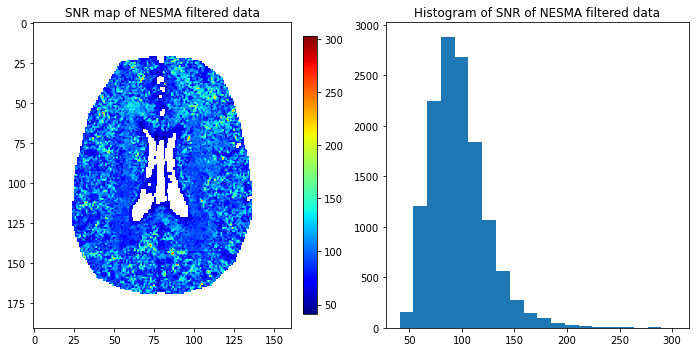

In [201]:
brain_SNR_map_NESMA = np.zeros((n_hori, n_vert))
for i_hori in trange(n_hori):
    for i_vert in range(n_vert):
        data = I_filtered[i_hori,i_vert,:]
        if data[0]>0:
            signal_end = data[(n_elements_brain-10):] #Accounting for noise in the data - Rician noise
            
            brain_noise_sd = np.std(signal_end)
            brain_SNR = data[0]/brain_noise_sd
            brain_SNR_map_NESMA[i_hori, i_vert] = brain_SNR
        else:
            brain_SNR_map_NESMA[i_hori, i_vert] = None
            
fig, ax = plt.subplots(1, 2, figsize=(10,5),tight_layout=True)
imc1 = ax[0].imshow(brain_SNR_map_NESMA, cmap = 'jet')
ax[0].set_title('SNR map of NESMA filtered data')

n, bins, patches = ax[1].hist(np.reshape(brain_SNR_map_NESMA[brain_SNR_map_NESMA>0],-1), bins=20)
bincenters_NESMA = 0.5*(bins[1:]+bins[:-1])
#print(bincenters_NESMA)
print('SNR mean:',np.mean(brain_SNR_map_NESMA[brain_SNR_map_NESMA>0]))
ax[1].set_title('Histogram of SNR of NESMA filtered data')

fig.colorbar(imc1,ax=ax[0],fraction=0.046, pad=0.04)

plt.show()

# Apply Unregularized NLLS to the Brain Data

In [202]:
parameter_maps_NLLS = create_NLLS_map(I_normalized)

100%|██████████| 191/191 [02:31<00:00,  1.26it/s]


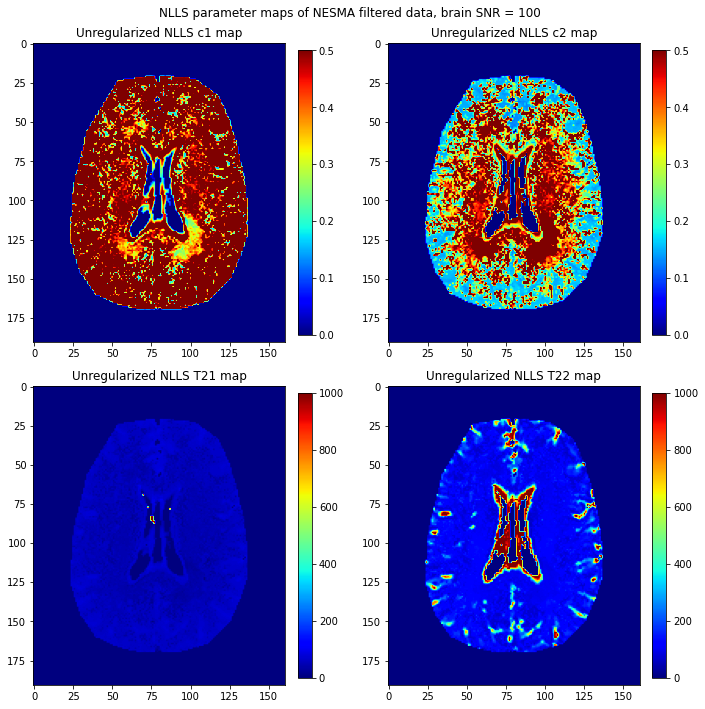

In [206]:
fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
fig.suptitle('NLLS parameter maps of NESMA filtered data, brain SNR = %s'%SNR_brain)
imc1 = ax[0,0].imshow(parameter_maps_NLLS[:,:,0], cmap = 'jet', vmin=0, vmax=0.5)
ax[0,0].set_title('Unregularized NLLS c1 map')

imc2 = ax[0,1].imshow(parameter_maps_NLLS[:,:,1], cmap = 'jet', vmin=0, vmax=0.5)
ax[0,1].set_title('Unregularized NLLS c2 map')

imT21 = ax[1,0].imshow(parameter_maps_NLLS[:,:,2], cmap = 'jet')
ax[1,0].set_title('Unregularized NLLS T21 map')

imT22 = ax[1,1].imshow(parameter_maps_NLLS[:,:,3], cmap = 'jet')
ax[1,1].set_title('Unregularized NLLS T22 map')

fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)
fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
plt.show()

# Apply GCV Reg-NLLS to the Brain Data

In [127]:
parameter_maps_GCV, lambda_map_GCV = create_GCV_map(I_normalized, lambdas)

  2%|▏         | 1/50 [00:45<37:12, 45.56s/it]

: 

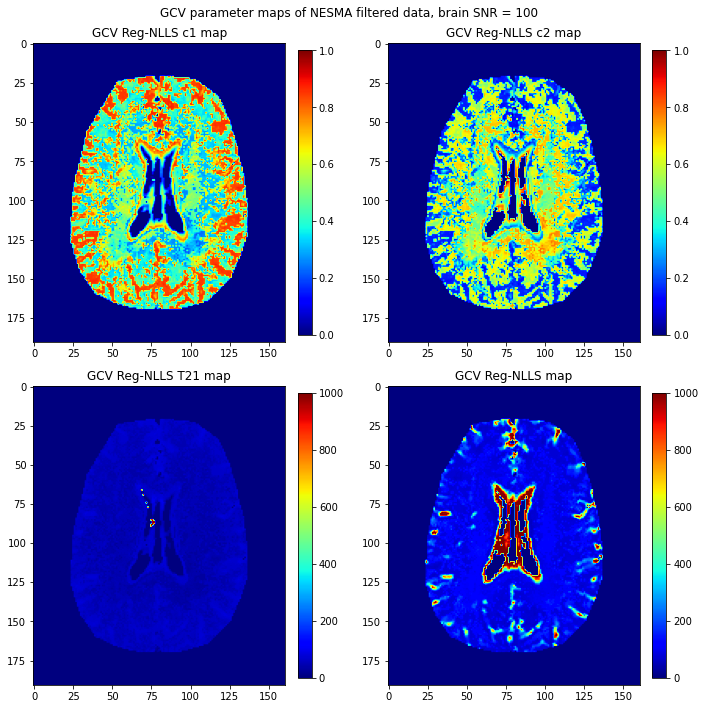

In [37]:
fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
fig.suptitle('GCV parameter maps of NESMA filtered data, brain SNR = %s'%(SNR_brain))
imc1 = ax[0,0].imshow(parameter_maps_GCV[:,:,0], cmap = 'jet', vmin=0, vmax=1)
ax[0,0].set_title('GCV Reg-NLLS c1 map')

imc2 = ax[0,1].imshow(parameter_maps_GCV[:,:,1], cmap = 'jet', vmin=0, vmax=1)
ax[0,1].set_title('GCV Reg-NLLS c2 map')

imT21 = ax[1,0].imshow(parameter_maps_GCV[:,:,2], cmap = 'jet')
ax[1,0].set_title('GCV Reg-NLLS T21 map')

imT22 = ax[1,1].imshow(parameter_maps_GCV[:,:,3], cmap = 'jet')
ax[1,1].set_title('GCV Reg-NLLS map')

fig.colorbar(imc1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(imc2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(imT21,ax=ax[1,0],fraction=0.046, pad=0.04)
fig.colorbar(imT22,ax=ax[1,1],fraction=0.046, pad=0.04)
plt.show()

# Apply DNN Reg-NLLS to the brain data

In [38]:
# parameter_maps_DNN, lambda_map_DNN = create_DNN_map(I_normalized, all_SNR = True)

In [39]:
# fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
# fig.suptitle('DNN parameter maps of NESMA filtered data, brain SNR = %s'%(SNR_brain))
# imc1 = ax[0,0].imshow(parameter_maps_DNN[:,:,0], cmap = 'jet')
# ax[0,0].set_title('DNN Reg-NLLS c1 map')

# imc2 = ax[0,1].imshow(parameter_maps_DNN[:,:,1], cmap = 'jet')
# ax[0,1].set_title('DNN Reg-NLLS c2 map')

# imT21 = ax[1,0].imshow(parameter_maps_DNN[:,:,2], cmap = 'jet')
# ax[1,0].set_title('DNN Reg-NLLS T21 map')

# imT22 = ax[1,1].imshow(parameter_maps_DNN[:,:,3], cmap = 'jet')
# ax[1,1].set_title('DNN Reg-NLLS map')

# fig.colorbar(imc1,ax=ax[0,0],fraction=0.046, pad=0.04)
# fig.colorbar(imc2,ax=ax[0,1],fraction=0.046, pad=0.04)
# fig.colorbar(imT21,ax=ax[1,0],fraction=0.046, pad=0.04)
# fig.colorbar(imT22,ax=ax[1,1],fraction=0.046, pad=0.04)
# plt.show()

# Generate Difference Maps

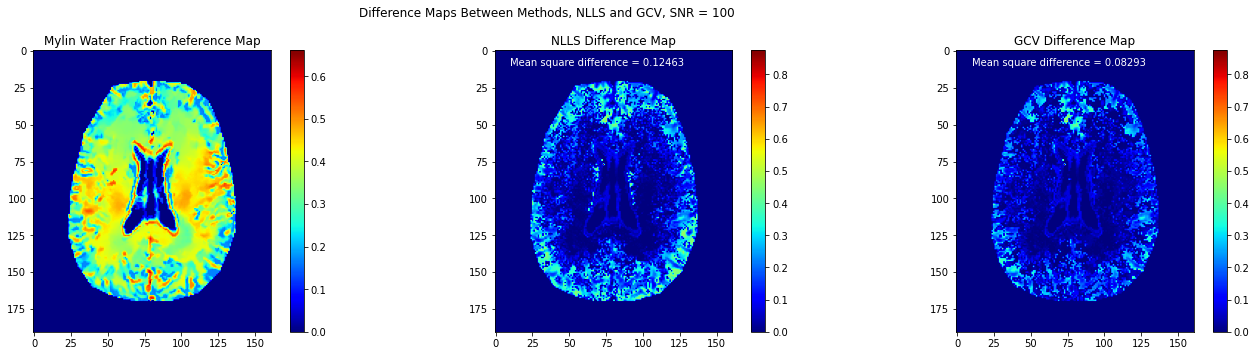

In [40]:
NLLS_diff = (parameter_maps_NLLS[:,:,0] - c1_ref)**2
NLLS_brain_bias = np.sum(NLLS_diff)/NLLS_diff[NLLS_diff>0].size
GCV_diff = (parameter_maps_GCV[:,:,0] - c1_ref)**2
GCV_brain_bias = np.sum(GCV_diff)/GCV_diff[GCV_diff>0].size

fig, ax = plt.subplots(1,3,figsize=(20,5),tight_layout=True)
fig.suptitle('Difference Maps Between Methods, NLLS and GCV, SNR = %s'%SNR_brain)
imref = ax[0].imshow(c1_ref, cmap = 'jet')
ax[0].set_title('Mylin Water Fraction Reference Map')

imNLLS = ax[1].imshow(NLLS_diff, cmap = 'jet', vmin=0, vmax=np.max([NLLS_diff,GCV_diff]))
ax[1].set_title('NLLS Difference Map')
ax[1].text(10, 10, 'Mean square difference = %s'%round(NLLS_brain_bias,5), color='w')
imGCV = ax[2].imshow(GCV_diff, cmap = 'jet', vmin=0, vmax=np.max([NLLS_diff,GCV_diff]))
ax[2].set_title('GCV Difference Map')
ax[2].text(10, 10, 'Mean square difference = %s'%round(GCV_brain_bias,5), color='w')

fig.colorbar(imref,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(imNLLS,ax=ax[1],fraction=0.046, pad=0.04)
fig.colorbar(imGCV,ax=ax[2],fraction=0.046, pad=0.04)
plt.show()

# Generate Map of Oracle Lambdas

In [41]:
lambda_map_oracle = np.zeros((n_hori, n_vert))
for i_hori in trange(n_hori):
    for i_vert in range(n_vert):
        data = I_filtered[i_hori,i_vert,:]
        #Check if there is signal present
        if data[0] > 0:
            data = data/data[0]
            try:
                oracle_lam = oracle_lambda_brain(c1_ref[i_hori,i_vert],data,lambdas,0)
                lambda_map_oracle[i_hori,i_vert] = oracle_lam
            except:
                lambda_map_oracle[i_hori,i_vert] = 0
        #If no signal, return zero for all parameters
        else:
            lambda_map_oracle[i_hori,i_vert] = 0

100%|██████████| 191/191 [2:45:40<00:00, 52.04s/it]   


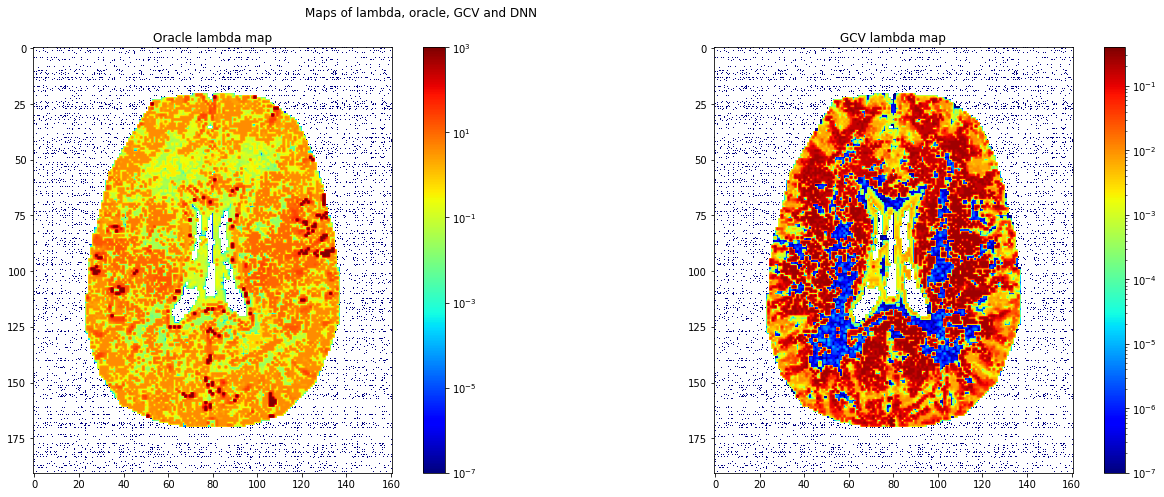

In [42]:
fig, ax = plt.subplots(1,2,figsize=(21,7),tight_layout=True)
fig.suptitle('Maps of lambda, oracle, GCV and DNN')
imOra = ax[0].imshow(lambda_map_oracle, cmap = 'jet', norm=mpl.colors.LogNorm())
ax[0].set_title('Oracle lambda map')

imGCV = ax[1].imshow(lambda_map_GCV, cmap = 'jet', norm=mpl.colors.LogNorm())
ax[1].set_title('GCV lambda map')

fig.colorbar(imOra,ax=ax[0],fraction=0.046,pad=0.04)
fig.colorbar(imGCV,ax=ax[1],fraction=0.046,pad=0.04)

plt.show()

# Save Code in an hdf5 File in the Output Folder

In [43]:
# Save a map
with h5py.File('Brain_Output//'+ output_fileName +'.hdf5','a') as f:
    #Save a data set
    dset = f.create_dataset('NLLS_params',data=parameter_maps_NLLS)
    dset = f.create_dataset('GCV_params',data=parameter_maps_GCV)
    dset = f.create_dataset('GCV_lambdas',data=lambda_map_GCV)
    dset = f.create_dataset('Oracle_lambdas',data=lambda_map_oracle)